Transfer Learning with CNN


### GPU connection Check

In [33]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Dec  1 22:31:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   77C    P0              34W /  72W |   1181MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Check memory availability

In [34]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 56.9 gigabytes of available RAM

You are using a high-RAM runtime!


### Import Libraries

In [35]:
# Core PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn

# Additional libraries
import numpy as np
import os
import time
from PIL import Image
from tempfile import TemporaryDirectory
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import shutil

# torchvision imports
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder




%matplotlib inline

cudnn.benchmark = True
plt.ion()   # interactive mode

### Import Data

In [37]:
!git clone https://github.com/jyassien/LPDI.git
!git clone https://github.com/pratikkayal/PlantDoc-Dataset.git

error: unknown option `force'
usage: git clone [<options>] [--] <repo> [<dir>]

    -v, --verbose         be more verbose
    -q, --quiet           be more quiet
    --progress            force progress reporting
    --reject-shallow      don't clone shallow repository
    -n, --no-checkout     don't create a checkout
    --bare                create a bare repository
    --mirror              create a mirror repository (implies bare)
    -l, --local           to clone from a local repository
    --no-hardlinks        don't use local hardlinks, always copy
    -s, --shared          setup as shared repository
    --recurse-submodules[=<pathspec>]
                          initialize submodules in the clone
    --recursive[=<pathspec>]
                          alias of --recurse-submodules
    -j, --jobs <n>        number of submodules cloned in parallel
    --template <template-directory>
                          directory from which templates will be used
    --reference <repo>    re

## Load Model

In [6]:
from torchvision.models import ResNet18_Weights

model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# num_classes = 8  # 8 variant classififcations of plants
# model.fc = nn.Linear(model.fc.in_features, num_classes)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 217MB/s]


## Allocate GPU for the model

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# print out which device is being used
print(f"Using device: {device}")

Using device: cuda


Load Data
=========


## 1. Data for finetuning the ConvNet

In [8]:
from torchvision import datasets, transforms

data_transforms_fine = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = '/content/PlantDoc-Dataset'


image_datasets_fine = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms_fine[x])
                  for x in ['train', 'test']}
dataloaders_fine = {x: torch.utils.data.DataLoader(image_datasets_fine[x], batch_size=20,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'test']}
dataset_sizes_fine = {x: len(image_datasets_fine[x]) for x in ['train', 'test']}
class_names_fine = image_datasets_fine['train'].classes

## 2. Data for ConvNet as fixed feature extractor

In [9]:
from torchvision import datasets, transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = '/content/LPDI/server/data/tomato/Variant_A'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=20,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes


## Examples of training images:


In [10]:
def imshow_grid(inputs, classes, class_names, num_rows=4):
    """Display images in a grid with class names above each image."""
    batch_size = inputs.size(0)
    inputs = inputs.cpu()  # matplotlib compatibility

    num_columns = batch_size // num_rows if batch_size % num_rows == 0 else (batch_size // num_rows) + 1

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 3, num_rows * 3))
    axes = axes.flatten()

    for idx, ax in enumerate(axes):
        if idx < batch_size:
            inp = inputs[idx].numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp = std * inp + mean
            inp = np.clip(inp, 0, 1)
            ax.imshow(inp)
            ax.set_title(class_names[classes[idx]], fontsize=12)
            ax.axis("off")
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()


### Dataset 1

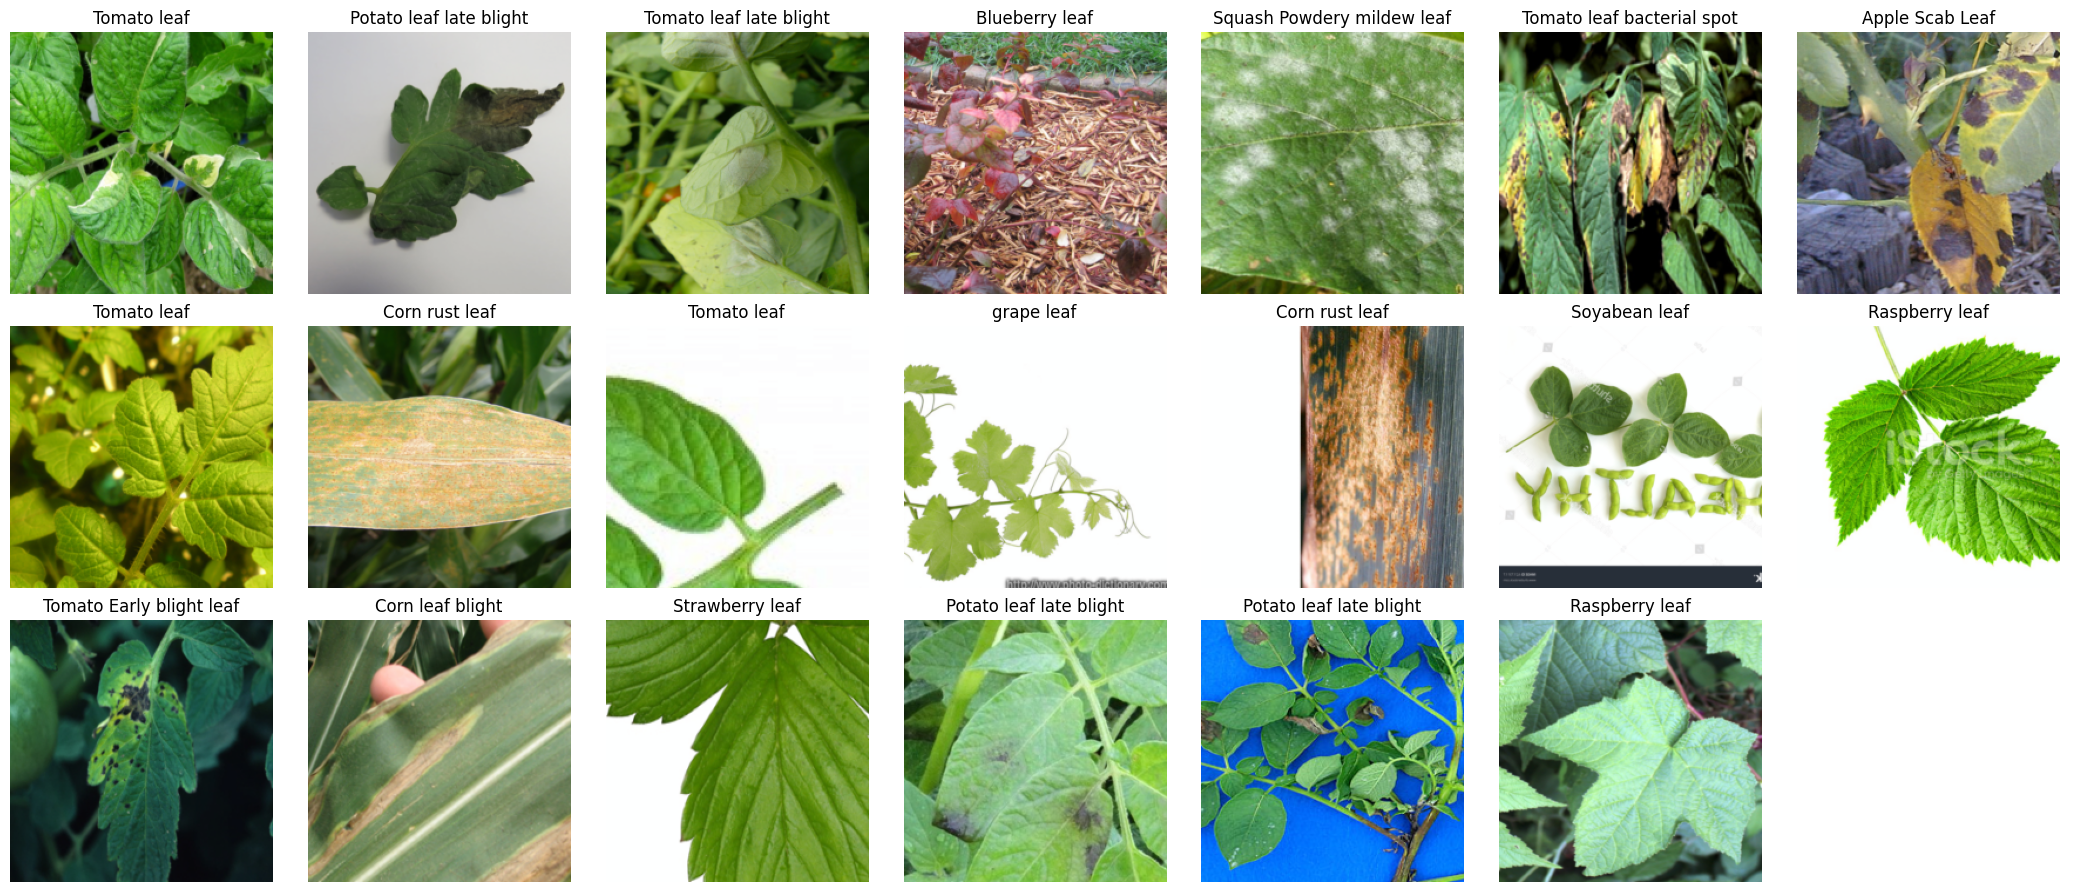

In [11]:
# Get a batch of training data
inputs_fine, classes_fine = next(iter(dataloaders_fine['train']))

training_examples_fine = imshow_grid(inputs_fine, classes_fine, class_names_fine, num_rows=3)

### Dataset 2

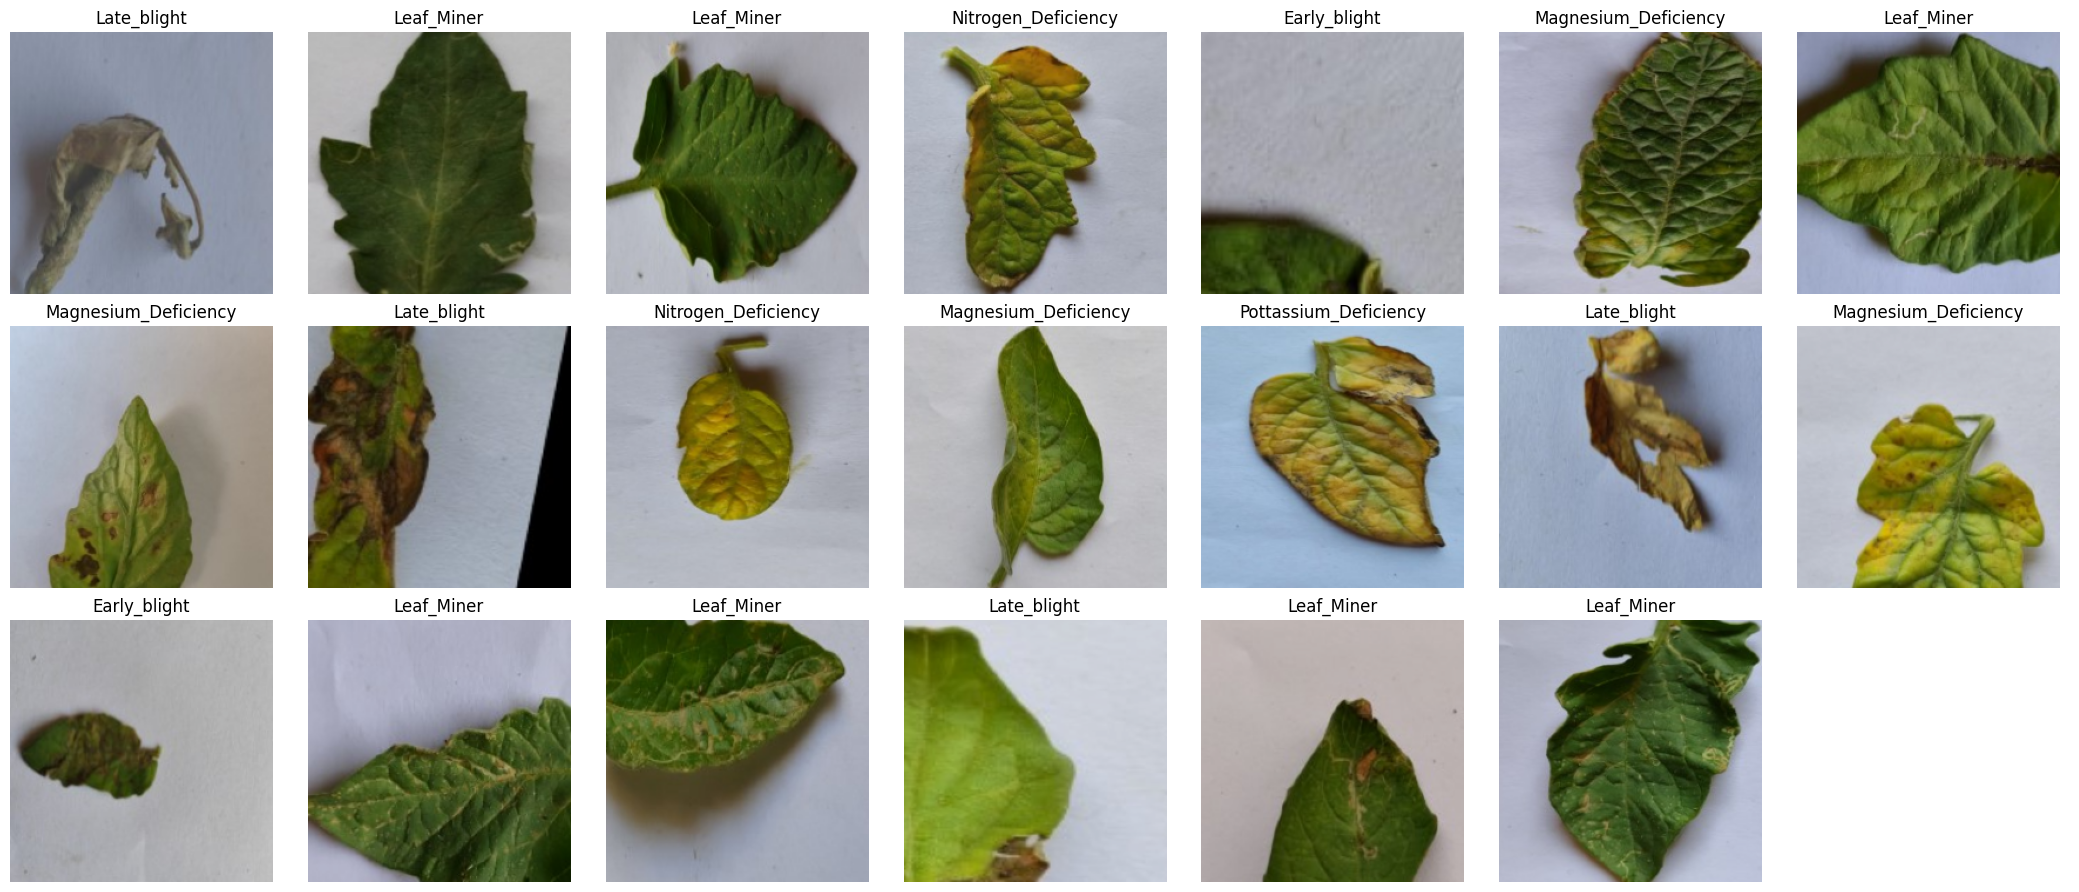

In [12]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

training_examples = imshow_grid(inputs, classes, class_names, num_rows=3)

## Model training method

In [13]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, val="val", num_epochs=25):
    since = time.time()
    b_losses = {'train':[], val:[]}
    e_losses = {'train':[], val:[]}

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch + 1}/{num_epochs}', end="")

            # Each epoch has a training and validation phase
            for phase in ['train', val]:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    b_losses[phase].append(loss.item())

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.float() / dataset_sizes[phase]

                # print loss and accuraacy every 4 epochs
                if epoch % 4 == 0:
                    print(f'\t{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}', end="\t")
                   # print('-' * 10)
                # save loss for plotting later on
                e_losses[phase].append(epoch_loss)

                # deep copy the model
                if phase == val and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, e_losses, b_losses

## 1. Fine-tuning the pretrained model with ConvNet


In [24]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features


print(f'Original number of input and output features of resnet18 : {model_ft.fc}')


model_ft.fc = nn.Linear(num_ftrs, len(class_names))

print(f'Updated number of input and output features of resnet18 :  {model_ft.fc}')


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

print("\nDone!")

Original number of input and output features of resnet18 : Linear(in_features=512, out_features=1000, bias=True)
Updated number of input and output features of resnet18 :  Linear(in_features=512, out_features=8, bias=True)

Done!


### Train and Evaluate

In [39]:
model_ft, epoch_losses, batch_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,dataloaders, "val", num_epochs=25)


Epoch 1/25	train Loss: 0.3314 Acc: 0.8912		val Loss: 0.3524 Acc: 0.8891	
Epoch 2/25
Epoch 3/25
Epoch 4/25
Epoch 5/25	train Loss: 0.3696 Acc: 0.8700		val Loss: 0.3614 Acc: 0.8858	
Epoch 6/25
Epoch 7/25
Epoch 8/25
Epoch 9/25	train Loss: 0.3573 Acc: 0.8754		val Loss: 0.3601 Acc: 0.8847	
Epoch 10/25
Epoch 11/25
Epoch 12/25
Epoch 13/25	train Loss: 0.3639 Acc: 0.8719		val Loss: 0.3665 Acc: 0.8814	
Epoch 14/25
Epoch 15/25
Epoch 16/25
Epoch 17/25	train Loss: 0.3354 Acc: 0.8884		val Loss: 0.3678 Acc: 0.8780	
Epoch 18/25
Epoch 19/25
Epoch 20/25
Epoch 21/25	train Loss: 0.3417 Acc: 0.8868		val Loss: 0.3565 Acc: 0.8858	
Epoch 22/25
Epoch 23/25
Epoch 24/25
Epoch 25/25	train Loss: 0.3506 Acc: 0.8786		val Loss: 0.3511 Acc: 0.8858	
Training complete in 2m 31s
Best val Acc: 0.889135


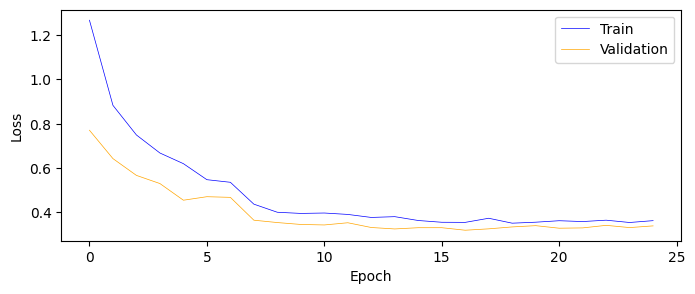

In [14]:
# plot the loss curves
plt.figure(figsize=(8, 3))
plt.plot(range(len(epoch_losses['train'])), epoch_losses['train'], c='blue', linewidth=0.5)
plt.plot(range(len(epoch_losses['val'])), epoch_losses['val'], c='orange', linewidth=0.5)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(('Train','Validation'))

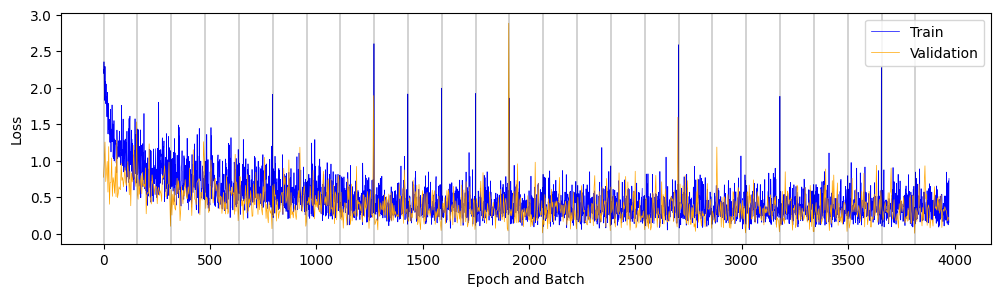

In [15]:
# plot the loss curves for each (mini) batch
plt.figure(figsize=(12, 3))
val_ticks = [(i)*len(batch_losses['train'])/len(batch_losses['val']) for i in range(len(batch_losses['val']))]
plt.plot(range(len(batch_losses['train'])), batch_losses['train'], c='blue', linewidth=0.5)
plt.plot(val_ticks, batch_losses['val'], c='orange', linewidth=0.5)
for i in range(25):
    plt.axvline(x=i*len(batch_losses['train'])/25, c='black', lw=0.25)
plt.ylabel('Loss')
plt.xlabel('Epoch and Batch')
plt.legend(('Train','Validation'))

## 2. Fine-tuning the pretrained model with ConvNet as fixed feature extractor


In [16]:
torch.save(model_ft.state_dict(), "model_ft_trained.pth")

In [26]:
import torchvision

model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

print(f'Original number of input and output features of resnet18 : {model_conv.fc}')


num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names_fine))

print(f'Updated number of input and output features of resnet18 :  {model_conv.fc}')

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Only parameters of final layer are being optimized.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

print("\nDone!")

Original number of input and output features of resnet18 : Linear(in_features=512, out_features=1000, bias=True)
Updated number of input and output features of resnet18 :  Linear(in_features=512, out_features=28, bias=True)

Done!


In [27]:
# Load the saved state_dict
state_dict = torch.load("model_ft_trained.pth")

# Remove the `fc` layer's weights to avoid mismatch
state_dict.pop("fc.weight", None)
state_dict.pop("fc.bias", None)

# Load the filtered state_dict into the new model
model_conv.load_state_dict(state_dict, strict=False)



<ipython-input-27-6a7898371338>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("model_ft_trained.pth")


_IncompatibleKeys(missing_keys=['fc.weight', 'fc.bias'], unexpected_keys=[])

### Train and Evaluate

In [28]:
model_conv, epoch_losses, batch_losses = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, dataloaders_fine, "test", num_epochs=25)

Epoch 1/25	train Loss: 1.6903 Acc: 0.2786		test Loss: 0.9912 Acc: 0.2343	
Epoch 2/25
Epoch 3/25
Epoch 4/25
Epoch 5/25	train Loss: 0.7996 Acc: 0.4911		test Loss: 0.8987 Acc: 0.2863	
Epoch 6/25
Epoch 7/25
Epoch 8/25
Epoch 9/25	test Loss: 0.9053 Acc: 0.2842	
Epoch 10/25
Epoch 11/25
Epoch 12/25
Epoch 13/25	train Loss: 0.6998 Acc: 0.5183		test Loss: 0.9107 Acc: 0.2863	
Epoch 14/25
Epoch 15/25
Epoch 16/25
Epoch 17/25	train Loss: 0.6968 Acc: 0.5228		test Loss: 0.9091 Acc: 0.2842	
Epoch 18/25
Epoch 19/25
Epoch 20/25
Epoch 21/25	train Loss: 0.6824 Acc: 0.5272		test Loss: 0.9206 Acc: 0.2907	
Epoch 22/25
Epoch 23/25
Epoch 24/25
Epoch 25/25	train Loss: 0.6878 Acc: 0.5240		test Loss: 0.9121 Acc: 0.2950	
Training complete in 12m 22s
Best val Acc: 0.297180


Perform testing on the ConvNet model
==================

In [16]:
def test_model(model, dataloaders, dataset_sizes, split='val', track_batches=False):
    """Evaluate the model on a specific split ('val' or 'test')."""
    model.eval()
    correct = 0
    total = 0
    batch_accuracies = []


    with torch.no_grad():
        for inputs, labels in dataloaders[split]:
            inputs, labels = inputs.to(device), labels.to(device)

            # Perform forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (preds == labels).sum().item()


            # Track batch accuracy
            if track_batches:
                batch_correct = (preds == labels).sum().item()
                batch_total = labels.size(0)
                batch_acc = 100.0 * batch_correct / batch_total
                batch_accuracies.append(batch_acc)

    # Compute accuracy
    accuracy = 100 * correct / total
    print(f'{split.capitalize()} Accuracy: {accuracy:.2f}%')

    if track_batches:
        return accuracy, batch_accuracies

    return accuracy



# Call the testing function and save the accuracy
accuracy = test_model(model_ft, dataloaders, dataset_sizes, split='test')





Test Accuracy: 90.46%


## Visualizing model *predictions*

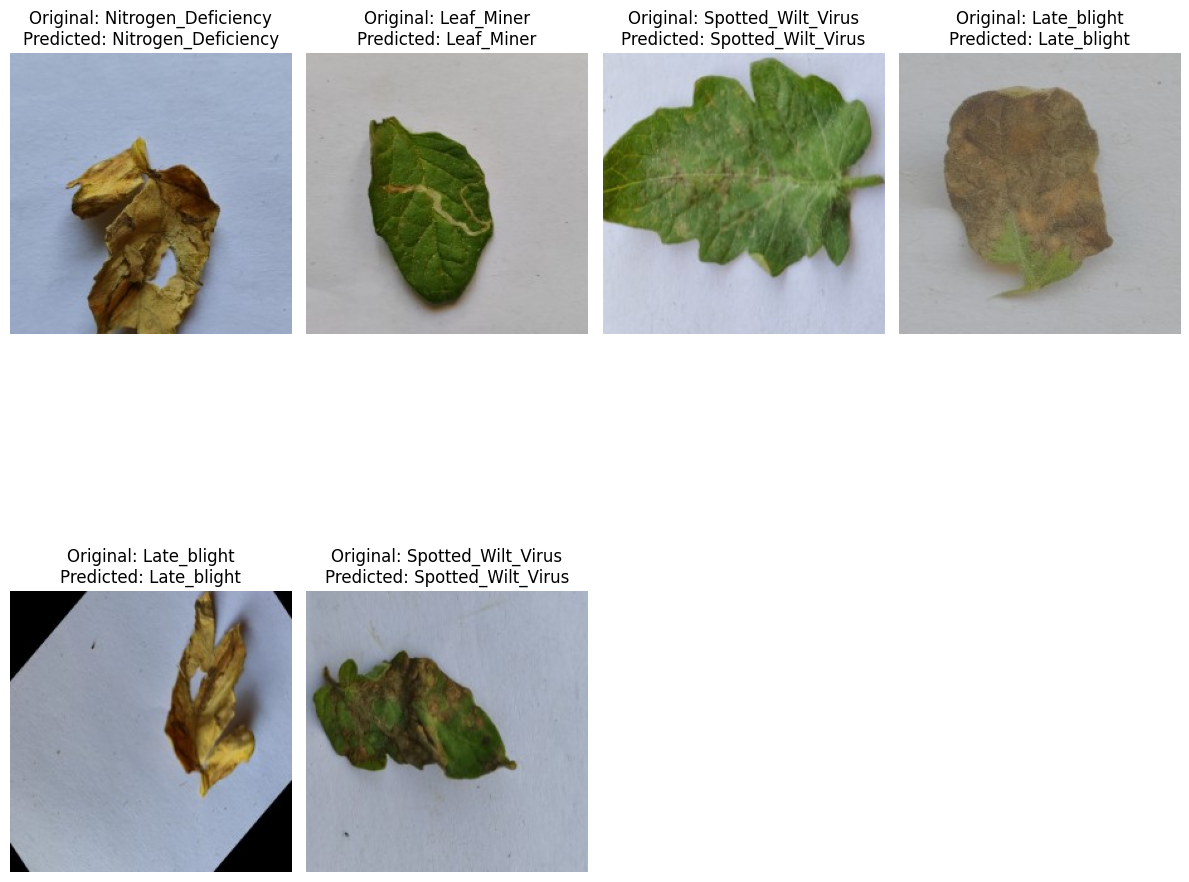

In [20]:
def imshow(inp, ax):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    ax.axis('off')


def visualize_model(model, dataloaders, class_names, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(12, 12))  # Initialize the figure

    num_rows = (num_images + 3) // 4  # Calculate rows for grid

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            batch_size = inputs.size(0)
            for j in range(batch_size):
                # Check if the label and prediction are within the bounds of class_names
                if labels[j].item() >= len(class_names) or preds[j].item() >= len(class_names):
                    print(f"Skipping label {labels[j].item()} or prediction {preds[j].item()} as it is out of range")
                    continue  # Skip this image if it's out of bounds

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.tight_layout()
                    return fig  # Ensure a valid figure is returned

                images_so_far += 1
                row = (images_so_far - 1) // 4
                col = (images_so_far - 1) % 4

                ax = plt.subplot(num_rows, 4, images_so_far)
                ax.set_title(f'Original: {class_names[labels[j]]}\nPredicted: {class_names[preds[j]]}')

                imshow(inputs.cpu().data[j], ax)

        model.train(mode=was_training)

    plt.tight_layout()
    return fig


figure = visualize_model(model_ft, dataloaders, class_names, num_images=6)





In [23]:
# Save the entire model (architecture + parameters)
torch.save(model_ft, "ResNet_model.pth")

# Alternatively, save only the model's state_dict (recommended for flexibility)
torch.save(model_ft.state_dict(), "ResNet_model_state.pth")

In [25]:
model_ft_saved = torch.load("ResNet_model.pth")
model_ft_saved.eval()
accuracy = test_model(model_ft_saved, dataloaders, dataset_sizes, split='test')


<ipython-input-25-3b46757d85c5>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft_saved = torch.load("ResNet_model.pth")


Test Accuracy: 90.46%


### Save Outputs


In [21]:
folder = '/content/model_summaries'
pdf_name = f'{model.__class__.__name__}_Finetuned_ConvNet_summary.pdf'
pdf_path = os.path.join(folder, pdf_name)

# Ensure the folder exists
if not os.path.exists(folder):
    os.makedirs(folder)


def save_to_pdf(pdf, figure):
    pdf.savefig(figure)
    plt.close(figure)


def save_model_outputs_to_pdf(model, accuracy, figure):

    with PdfPages(pdf_path) as pdf:
        # Validation accuracy
        fig = plt.figure(figsize=(8, 4))
        plt.text(0.5, 0.5, f"Model: {model.__class__.__name__}_Finetuned_ConvNet\nValidation Accuracy: {accuracy:.2f}%",
                 horizontalalignment='center', verticalalignment='center', fontsize=18)
        plt.axis('off')
        save_to_pdf(pdf, fig)

        # Predictions visualization)
        save_to_pdf(pdf, figure)  # Save the figure visualizing predictions

    print(f"Model summary saved to {pdf_path}")


save_model_outputs_to_pdf(model, accuracy, figure)

Model summary saved to /content/model_summaries/ResNet_Finetuned_ConvNet_summary.pdf


# Save to GitHub folder




In [ ]:
git_path = f'/content/LPDI/server/model/model_summaries/{pdf_name}'
shutil.copy(pdf_path, git_path)

%cd /content/LPDI



/content/LPDI


### Save to local machine

In [ ]:
from google.colab import files
files.download(pdf_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>